In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/liar_dataset/processed_dataset

/content/drive/MyDrive/liar_dataset/processed_dataset


训练集标签分布:
label
half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: count, dtype: int64
验证集标签分布:
label
false          263
mostly-true    251
half-true      248
barely-true    237
true           169
pants-fire     116
Name: count, dtype: int64
测试集标签分布:
label
half-true      265
false          249
mostly-true    241
barely-true    212
true           208
pants-fire      92
Name: count, dtype: int64
📊 Classification Report:
              precision    recall  f1-score   support

  pants-fire       0.27      0.23      0.25       212
       false       0.26      0.33      0.29       249
 barely-true       0.22      0.28      0.25       265
   half-true       0.24      0.24      0.24       241
 mostly-true       0.24      0.04      0.07        92
        true       0.24      0.19      0.21       208

    accuracy                           0.24      1267
   macro avg       0.24      0.22      0.22      1267
weighted avg    

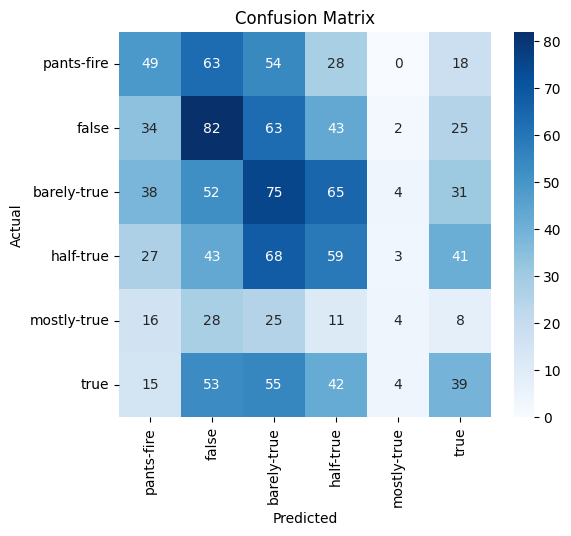


 Top 5 Misclassified Samples:

[0] Statement: building wall usmexico border take literally years
    ➤ True: 5 | Pred: 1
[4] Statement: asked reporter hes center criminal scheme violate campaign laws gov scott walker nodded yes
    ➤ True: 0 | Pred: 1
[6] Statement: says tennessee law requires schools receive half proceeds year halfcent increase shelby county sales tax
    ➤ True: 5 | Pred: 1
[8] Statement: donald trump is marriage equality wants go back
    ➤ True: 5 | Pred: 4
[11] Statement: politifact texas says congressman edwards attacks bill flores are false
    ➤ True: 2 | Pred: 3


,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,clean_statement,clean_statement_svm,true_label,predicted_label,correct
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,building wall usmexico border take literally y...,building wall usmexico border take literally y...,true,false,False
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,wisconsin pace double number layoffs year,wisconsin is pace double number layoffs year,false,false,True
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.,says john mccain done nothing help vets,says john mccain has done nothing help vets,false,false,True
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show,suzanne bonamici supports plan cut choice medi...,suzanne bonamici supports plan cut choice medi...,half-true,half-true,True
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,unknown,Wisconsin,democrat,5,7,2,2,7,a web video,asked reporter whether hes center criminal sch...,asked reporter hes center criminal scheme viol...,pants-fire,false,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,7334.json,half-true,Says his budget provides the highest state fun...,education,rick-scott,Governor,Florida,republican,28,23,38,34,7,a news conference,says budget provides highest state funding lev...,says budget provides highest state funding lev...,half-true,mostly-true,False
1263,9788.json,barely-true,Ive been here almost every day.,"civil-rights,crime,criminal-justice",jay-nixon,Governor,Missouri,democrat,2,0,0,1,0,"on ABC's ""This Week""",ive almost every day,ive been here almost day,barely-true,true,False
1264,10710.json,barely-true,"In the early 1980s, Sen. Edward Kennedy secret...","bipartisanship,congress,foreign-policy,history",mackubin-thomas-owens,"senior fellow, Foreign Policy Research Institute",Rhode Island,columnist,1,0,0,0,0,a commentary in The Providence Journal,early sen edward kennedy secretly offered help...,early s sen edward kennedy secretly offered he...,barely-true,mostly-true,False
1265,3186.json,barely-true,Says an EPA permit languished under Strickland...,"environment,government-efficiency",john-kasich,"Governor of Ohio as of Jan. 10, 2011",Ohio,republican,9,8,10,18,3,a news conference,says epa permit languished strickland new epa ...,says epa permit languished strickland new epa ...,barely-true,mostly-true,False


In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


train_df = pd.read_csv('processed_train.csv')
val_df = pd.read_csv('processed_valid.csv')
test_df = pd.read_csv('processed_test.csv')


print("训练集标签分布:")
print(train_df["label"].value_counts())

print("验证集标签分布:")
print(val_df["label"].value_counts())

print("测试集标签分布:")
print(test_df["label"].value_counts())


def extract_features(train_df, val_df, test_df, max_features=5000):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=max_features)

    X_train = vectorizer.fit_transform(train_df["clean_statement_svm"])
    X_val = vectorizer.transform(val_df["clean_statement_svm"])
    X_test = vectorizer.transform(test_df["clean_statement_svm"])

    y_train = train_df["label"]
    y_val = val_df["label"]
    y_test = test_df["label"]

    return X_train, X_val, X_test, y_train, y_val, y_test, vectorizer

def train_svm_model(X_train, y_train, C=1.0, kernel='linear'):
    svm_model = SVC(C=C, kernel=kernel, decision_function_shape='ovr')
    svm_model.fit(X_train, y_train)
    return svm_model


def predict_and_evaluate(model, X_test, y_test, label_map={0: "pants-fire", 1: "false", 2: "barely-true", 3: "half-true", 4: "mostly-true", 5: "true"}):

    y_pred = model.predict(X_test)


    print("📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_map.values()))


    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_map.values(), yticklabels=label_map.values())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return y_pred

def analyze_predictions(preds, test_df, label_col="label", label_map={0: "pants-fire", 1: "false", 2: "barely-true", 3: "half-true", 4: "mostly-true", 5: "true"}, top_k=5):

    reverse_label_map = {v: k for k, v in label_map.items()}
    true_labels = test_df[label_col].tolist()
    test_df["true_label"] = test_df[label_col]
    test_df["predicted_label"] = preds
    test_df["correct"] = test_df["true_label"] == test_df["predicted_label"]

    print(f"\n Top {top_k} Misclassified Samples:\n")
    mistakes = test_df[~test_df["correct"]].head(top_k)
    for i, row in mistakes.iterrows():

        true_label_text = reverse_label_map[row['true_label']]
        predicted_label_text = reverse_label_map[row['predicted_label']]

        print(f"[{i}] Statement: {row['clean_statement_svm']}")
        print(f"    ➤ True: {true_label_text} | Pred: {predicted_label_text}")

    return test_df




X_train, X_val, X_test, y_train, y_val, y_test, vectorizer = extract_features(train_df, val_df, test_df)
svm_model = train_svm_model(X_train, y_train)
preds = predict_and_evaluate(svm_model, X_test, y_test)
analyze_predictions(preds, test_df)